In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!!pip install --upgrade --force-reinstall --no-deps kaggle
![ -d ~/.kaggle ] || mkdir ~/.kaggle
![ -f ~/.kaggle/kaggle.json ] || cp /content/drive/MyDrive/kaggle_api/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
![ -f /content/tabular-playground-series-jun-2021.zip ] || kaggle competitions download -c tabular-playground-series-jun-2021 && unzip /content/tabular-playground-series-jun-2021.zip

Mounted at /content/drive
 51% 5.00M/9.89M [00:00<00:00, 30.8MB/s]
100% 9.89M/9.89M [00:00<00:00, 48.1MB/s]
Archive:  /content/tabular-playground-series-jun-2021.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


### Data preparation
- Clean the data
- Convert to numpy array

In [4]:
sample_data = pd.read_csv('train.csv')
sample_data.fillna(0,inplace=True)
dummy_column = []
for col in sample_data.columns:
    if(sample_data[col].nunique()<30):
        if(col=="target"):
            continue
        dummy_column.append(col)

sample_data = pd.get_dummies(sample_data,columns=dummy_column)
# new_data.head()

In [5]:


train_data = sample_data.sample(frac=0.80,random_state=0)
test_data = sample_data.drop(train_data.index)

train_data.reset_index(inplace=True,drop=True)
# Class_1 -> 1-1 = 0
train_data['target'] = train_data['target'].apply(lambda x: int(x[-1:])-1)
# train_data.head()

test_data.reset_index(inplace=True,drop=True)
test_data['target'] = test_data['target'].apply(lambda x: int(x[-1:])-1)
# test_data.head()

train_id = train_data['id']
test_id = test_data['id']

train_data.drop(columns='id',inplace=True)
test_data.drop(columns='id',inplace=True)

# train_data.head()
# test_data.head()

### Normalize the data:
- Super important
- Otherwise overflow/underflow error : Due to sigmoid and/or exponential


In [6]:
# Treat all columns as normal variables taking values over real/natural numbers
train_label = np.array(train_data['target'])
train_label.shape = (train_label.shape[0])
print(train_label.shape)
# print(train_label)
train = train_data.drop(columns=['target'])
train = np.array(train)
# train = train / np.linalg.norm(train)
print(train.shape)
# print(train)

test_label = np.array(test_data['target'])
test_label.shape = (test_label.shape[0])
print(test_label.shape)
# print(test_label)
test = test_data.drop(columns=['target'])
test = np.array(test)
# test = test/np.linalg.norm(test)
print(test.shape)
# print(test)

(160000,)
(160000, 516)
(40000,)
(40000, 516)


PyTorch Implementation

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from torchvision import transforms, datasets

In [8]:
p_train = torch.from_numpy(train).float()
# print(p_train)
p_train_label = torch.from_numpy(train_label)
# print(p_train_label.unique())
p_test = torch.from_numpy(test).float()
p_test_label = torch.from_numpy(test_label)

In [9]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y


    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

Epoch 1 : Loss = 2.7904416620731354 Correctness = 9.542499901726842
Validation loss decreased (inf --> 2.212374).  Saving model ...
Epoch 2 : Loss = 2.748127579689026 Correctness = 17.013124423101544
Validation loss decreased (2.212374 --> 2.173311).  Saving model ...
Epoch 3 : Loss = 2.6928450912237167 Correctness = 26.906874496489763
Validation loss decreased (2.173311 --> 2.119837).  Saving model ...
Epoch 4 : Loss = 2.622824013233185 Correctness = 32.33937453478575
Validation loss decreased (2.119837 --> 2.065183).  Saving model ...
Epoch 5 : Loss = 2.564084902405739 Correctness = 32.42312464863062
Validation loss decreased (2.065183 --> 2.040406).  Saving model ...
Epoch 6 : Loss = 2.539755180478096 Correctness = 31.183749437332153
Validation loss decreased (2.040406 --> 2.020527).  Saving model ...
Epoch 7 : Loss = 2.507249489426613 Correctness = 31.862499192357063
Validation loss decreased (2.020527 --> 1.989310).  Saving model ...
Epoch 8 : Loss = 2.4740705266594887 Correctness

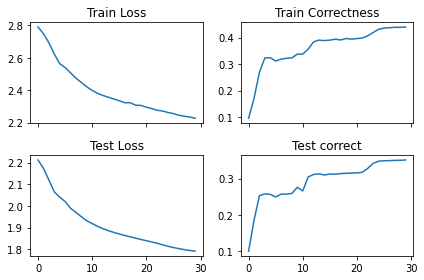

In [10]:
model = nn.Sequential(nn.Linear(516,250),
                      nn.ReLU(),
                      nn.Linear(250,125),
                      nn.ReLU(),
                      nn.Linear(125,50),
                      nn.ReLU(),
                      nn.Linear(50,20),
                      nn.ReLU(),
                      nn.Linear(20,9))


# def weights_init(m):
#     if isinstance(m, nn.Linear):
#         nn.init.xavier_uniform_(m.weight.data)
# model.apply(weights_init)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0005)
if torch.cuda.is_available():
  model = model.cuda()

optimizer.zero_grad()
epoch = 30
batch_size = 50000

# transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize((0.5, ), (0.5, ))])
b_train = MyDataset(p_train,p_train_label)
b_train_loader = torch.utils.data.DataLoader(b_train,batch_size=batch_size,shuffle=True)

train_loss = []
train_correct = []
test_loss = []
test_correct = []
t_loss_min = np.Inf
for i in range(epoch):
    running_loss = 0
    running_correct = 0
    model.train()
    for p_train_batch,p_train_label_batch in b_train_loader:

        if torch.cuda.is_available():
            p_train_batch = p_train_batch.cuda()
            p_train_label_batch = p_train_label_batch.cuda()

        p_train_pred_batch = model(p_train_batch)
        loss = criterion(p_train_pred_batch,p_train_label_batch)

        # Calculate Gradient
        """
        By default,gradients are accumulated i.e.
        After each .backward() call, calculate the gradients
        and add them to previously stored gradients.
        We wish to calculate fresh gradients each time
        so set stored gradients to zero first.
        """
        optimizer.zero_grad()
        loss.backward()
        # Update weights based on gradients
        optimizer.step()

        # Optional Part
        # print(loss.item())
        running_loss += loss.item()
        _,p_train_correct_class_batch = torch.max(p_train_pred_batch,1)
        correct_batch = torch.mean(torch.eq(p_train_correct_class_batch,p_train_label_batch).float()).item()
        # print(correct_batch*100)
        running_correct += correct_batch
    # Optional

    model.eval()
    if torch.cuda.is_available():
        p_test = p_test.cuda()
        p_test_label = p_test_label.cuda()
    # p_train = p_train.cuda()
    # p_train_label = p_train_label.cuda()
    running_loss = running_loss / (p_train.size()[0]/batch_size)
    running_correct = running_correct/(p_train.size()[0]/batch_size)
    print("Epoch " + str(i+1) + " : Loss = " + str(running_loss) + " Correctness = " + str(100*running_correct))
    train_loss.append(running_loss)
    train_correct.append(running_correct)
    p_test_pred = model(p_test)
    t_loss = criterion(p_test_pred,p_test_label)
    test_loss.append(t_loss.item())
    _,p_test_correct = torch.max(p_test_pred,1)
    test_correct.append(torch.mean(torch.eq(p_test_correct,p_test_label).float()).item())

    # Save Best model
    if t_loss <= t_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        t_loss_min,
        t_loss))
        torch.save(model.state_dict(), 'model.pt')
        t_loss_min = t_loss

print("Final Training Correctness {:.2f}%".format(train_correct[-1]*100))
print("Final Test Correctness {:.2f}%".format(test_correct[-1]*100))
print("Final Training Loss {:.6f}".format(train_loss[-1]))
print("Final Test Loss {:.6f}".format(test_loss[-1]))
print("Minimum Test Loss: {:6f}".format(t_loss_min))
fig,ax = plt.subplots(2,2,sharex=True)
ax[0][0].plot(train_loss)
ax[0][0].set_title('Train Loss')
ax[0][1].plot(train_correct)
ax[0][1].set_title('Train Correctness')

ax[1][0].plot(test_loss)
ax[1][0].set_title('Test Loss')
ax[1][1].plot(test_correct)
ax[1][1].set_title('Test correct')
fig.tight_layout()

PREDICTION

In [11]:
model.load_state_dict(torch.load('model.pt'))
kaggle_data = pd.read_csv('test.csv')

kaggle_data.fillna(0,inplace=True)
kaggle_data = pd.get_dummies(kaggle_data,columns=dummy_column)
kaggle_id = kaggle_data['id']
kaggle_data.drop(columns='id',inplace=True)
with torch.no_grad():
    kaggle_data = torch.tensor(kaggle_data.to_numpy()).float()
    if torch.cuda.is_available():
        kaggle_data = kaggle_data.cuda()
    kaggle_pred = F.softmax(model(kaggle_data),dim=1)
    print(kaggle_pred[0])


kaggle_pred = np.array(kaggle_pred.detach().cpu())
final = pd.DataFrame(kaggle_pred,index=kaggle_id,columns=["Class_"+ str(i+1) for i in range(9)])
final.to_csv("final.csv")

tensor([0.0375, 0.3208, 0.1400, 0.0172, 0.0200, 0.1932, 0.0328, 0.1337, 0.1047],
       device='cuda:0')


In [12]:
!kaggle competitions submit -c tabular-playground-series-jun-2021 -f final.csv -m "Multiple Dummy variables + Very Deep Model"

100% 10.4M/10.4M [00:02<00:00, 5.28MB/s]
Successfully submitted to Tabular Playground Series - Jun 2021